In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../")

import pandas as pd
import scipy
from scipy import stats as stats
import numpy as np
from functools import partial
import copy
import seaborn as sns

# from generic.latexify import *

from utilities import *
from payment.payment_functions import *
from payment.payment_function_evaluation import *
from payment.payment_function_templates import *


In Rideaustin_reverse_engineer_prices.ipynb, I figured out what the form of the prices looks like, for about a two month period. There needs to be some tweaking to that function to find the exact parameters that minimizes the distance between the reverse engineered fare, and the actual total fare. 

In payment_functions.py, I have the various payment functions that take in parameters using which I can make the functions close to the actual total_fare, and have the same total payments as each other.

In this file, I:

1. Calculate two parameters for the reverse engineered fare -- the multiplier, and the additive value for the fare.
1. For each alternate way to pay drivers, I calculate the parameter that equalizes the total spend to that of the calculated fare. 


Later:

1. I can use the calculated fare function to fill in the missing fares for the trips that I threw out. (maybe will need some rebalancing for the other functions, but that should be easy)
1. Move to a .py script for easy running in a pipeline. 
1. Think about at what level I want to calculate these parameters -- for the entire 2 month period, for each "surge," whatever that means, ...?

# standard setup

In [3]:
folder = '../data/rideaustin/'
filename = 'rides4_validreverseengineered.csv'

In [4]:
df = load_data(folder, filename)

C:\Users\Nikhil\OneDrive\CurrentDocuments\Stanford\Research\DriveSurgeData\Empirics\envs\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df_10hours = load_data(folder, 'rides4_10hours.csv')
df_oneday = load_data(folder, 'rides4_24hours.csv')
df_3weeks = load_data(folder, 'rides4_3weeks.csv')

In [6]:
df_small = df.sample(1000)

In [7]:
dfs = [df, df_10hours, df_oneday, df_3weeks, df_small]
df_names = ['', '_10hrs', '_24hrs', '_3weeks', '_small']

# Get reverse engineered one close to total_fare -- both parameters grid search

1.0101 2.0205


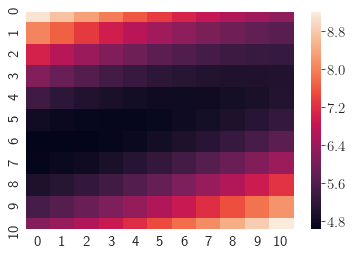

In [16]:
dfloc = df_small
multparam = np.linspace(1.0095, 1.0105, 11) #[1.017] #
addparam = np.linspace(2.02, 2.025, 11)
distances = np.zeros((len(multparam), len(addparam)))

for enm, m in enumerate(multparam):
    for ena, a in enumerate(addparam):
        dfwithfare = reverse_engineer_withparams(dfloc, m, a, col_name = 'reverse_engineer_fare')
        distances[enm, ena] = distance_l1(dfwithfare)
        
sns.heatmap(distances)
mins = argmin(distances)
mins
print(multparam[mins[0]], addparam[mins[1]])

In [17]:
dfloc[['total_fare', 'reverse_engineer_fare', 'miles', 'rate_per_mile', 'ride_total_time_seconds', 'rate_per_minute', 'base_fare', 'surge_factor', 'start_hour']].dropna().head(10)

,total_fare,reverse_engineer_fare,miles,rate_per_mile,ride_total_time_seconds,rate_per_minute,base_fare,surge_factor,start_hour
337358,7.99,8.004860,2.892482,0.99,373.0,0.25,1.5,1.00,6971.692778
437227,37.11,37.124129,15.254658,0.99,1573.0,0.25,1.5,1.50,7246.815833
203114,48.46,48.490651,16.035100,0.99,1348.0,0.25,1.5,2.00,6744.380000
113184,20.16,20.172282,11.115706,0.99,1309.0,0.25,1.5,1.00,6520.426111
320803,16.77,16.761626,4.521717,0.99,899.0,0.25,1.5,1.50,6912.171944
482655,6.98,6.983967,1.568962,0.99,445.0,0.25,1.5,1.00,7389.724167
184292,10.25,10.258013,3.987338,0.99,648.0,0.25,1.5,1.00,6717.422778
177051,8.81,8.807781,3.168992,0.99,498.0,0.25,1.5,1.00,6708.175556
379528,9.09,9.098500,1.086778,0.99,285.0,0.25,1.5,1.75,7078.663056
324998,11.01,11.011304,5.312722,0.99,512.0,0.25,1.5,1.00,6919.352778


In [19]:
(dfloc.total_fare - dfloc.reverse_engineer_fare).abs().mean(skipna = True)

0.009378868715414334

Params -- multiplier: 1.01, additive: 2.02

Will not include the additive component since that part doesn't go to the driver (according to how rideaustin pay calculator is online)

In [11]:
df = reverse_engineer_withparams(df, 1.01, 0, col_name = 'mimic_fare')
df_small = reverse_engineer_withparams(df_small, 1.01, 0, col_name = 'mimic_fare')
df_10hours = reverse_engineer_withparams(df_10hours, 1.01, 0, col_name = 'mimic_fare')
df_oneday = reverse_engineer_withparams(df_oneday, 1.01, 0, col_name = 'mimic_fare')
df_3weeks = reverse_engineer_withparams(df_3weeks, 1.01, 0, col_name = 'mimic_fare')

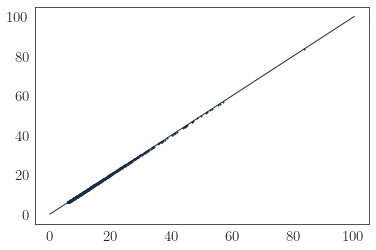

In [24]:
plt.scatter(df_small.reverse_engineer_fare, df_small.total_fare)
plt.plot(np.linspace(0, 100, 100), np.linspace(0, 100, 100))

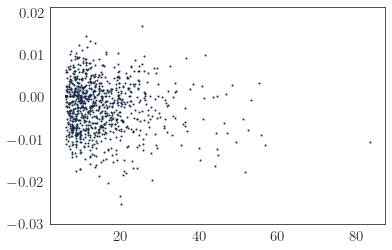

In [29]:
plt.scatter(df_small.total_fare, df_small.mimic_fare - df_small.total_fare + 2.02)

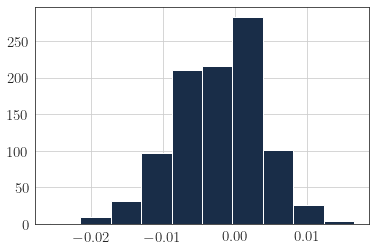

In [30]:
(df_small.mimic_fare - df_small.total_fare + 2.02).hist()

# For each of the datasets, find pure additive and pure multiplicative surge functions that don't transfer money between surges

These in effect treat the surge factors as discrete levels, and finds the "real" surge multiplier or additive value

In [12]:
def find_parameters_for_dataset(dfloc, dfname):
    unique_surge_factors = dfloc.surge_factor.unique()
    
    func_mult = partial(pure_multiplicative_withparams, col_name = 'pure_mult_bysurgefactor_fare')
    multipliers_by_surge = {}
    additive_by_surge = {}

    for surge_factor in unique_surge_factors:
        dflocsurge = dfloc.query('surge_factor == @surge_factor')
        multipliers_by_surge[surge_factor] = binary_search_to_find_parameter(dflocsurge, func_mult, 'mimic_fare', 'pure_mult_bysurgefactor_fare', print_stuff = False)  
        
        func_add = partial(pure_additive_withparams, col_name = 'pure_add_bysurgefactor_fare', multiplier_to_match_reverse = multipliers_by_surge[surge_factor])
   
        additive_by_surge[surge_factor] = binary_search_to_find_parameter(dflocsurge, func_add, 'mimic_fare', 'pure_add_bysurgefactor_fare', print_stuff = False)  
    
    print('multipliers_by_surge{} = {}'.format(dfname,multipliers_by_surge))
    print('additives_by_surge{} = {}'.format(dfname,additive_by_surge))
    
    #test that they work, by plotting mean surge payments by surge factor
    func_mult_bysurge = partial(pure_multiplicative_bysurgefactor_withparams, multipliers_by_surge = multipliers_by_surge, col_name = 'pure_mult_bysurgefactor_fare')
    dfloc = func_mult_bysurge(dfloc)

    func_add_bysurge = partial(pure_additive_bysurgefactor_withparams, multipliers_by_surge = multipliers_by_surge, additives_by_surge = additive_by_surge, col_name = 'pure_addsurge_bysurgefactor_fare')
    dfloc = func_add_bysurge(dfloc)

    plot_meanpayment_bysurgefactor(dfloc, ['pure_mult_bysurgefactor_fare', 'pure_addsurge_bysurgefactor_fare', 'mimic_fare'])
    plt.show()

In [13]:
# find_parameters_for_dataset(df_small)

multipliers_by_surge = {1.0: 1.178897671343293, 1.25: 1.2159457663074136, 1.5: 1.2160108075477183, 2.0: 1.2208759784698486, 1.75: 1.2208770494908094, 2.25: 1.2109917122870684, 2.5: 1.2150291353464127, 3.0: 1.2011436047032475, 2.75: 1.1996255721896887, 3.25: 1.1975256726145744, 3.5: 1.1947848368436098, 4.0: 1.1625474784523249, 3.75: 1.1804979294538498, 4.25: 1.1852897703647614, 4.5: 1.1432667262852192, 5.0: 1.1957231909036636}
additives_by_surge = {1.0: 50.0, 1.25: 9.453221783041954, 1.5: 9.58840111270547, 2.0: 9.615769982337952, 1.75: 9.59403170272708, 2.25: 9.957537800073624, 2.5: 9.92576852440834, 3.0: 10.548560321331024, 2.75: 10.640523582696915, 3.25: 10.865232348442078, 3.5: 11.063981056213379, 4.0: 12.741836160421371, 3.75: 12.023007869720459, 4.25: 11.503374576568604, 4.5: 14.593739807605743, 5.0: 11.09071969985962}


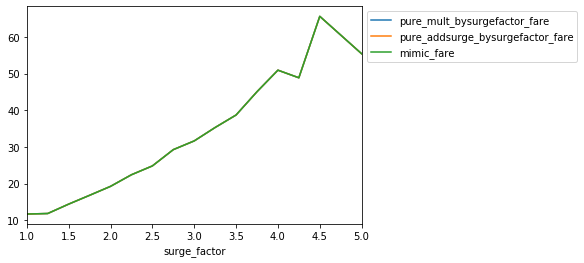

multipliers_by_surge_10hrs = {2.0: 1.2199825141578913, 1.75: 1.2184856459498405, 2.25: 1.2028269469738007, 1.5: 1.1831541545689106, 1.0: 1.1087017133831978, 1.25: 1.1369101703166962, 2.5: 1.1962052434682846, 2.75: 1.1761847883462906, 3.0: 1.1756353080272675, 3.25: 1.199445128440857, 3.5: 1.1748194694519043, 3.75: 1.186758279800415, 4.0: 1.1583805084228516, 4.5: 1.1570930480957031}
additives_by_surge_10hrs = {2.0: 9.505422785878181, 1.75: 9.625808894634247, 2.25: 10.010084509849548, 1.5: 11.15148589015007, 1.0: 50.0, 1.25: 14.945030212402344, 2.5: 10.335464775562286, 2.75: 11.482319235801697, 3.0: 11.691039800643921, 3.25: 10.655009746551514, 3.5: 12.554585933685303, 3.75: 10.171842575073242, 4.0: 11.826705932617188, 4.5: 11.9171142578125}


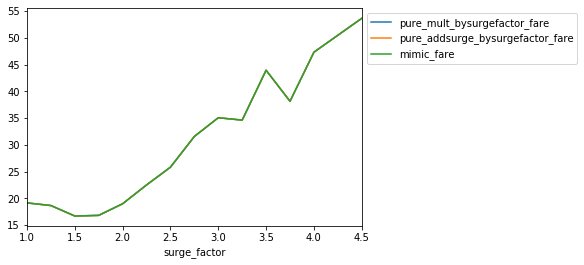

multipliers_by_surge_24hrs = {1.5: 1.1865070788189769, 1.0: 1.1202968191355467, 1.25: 1.1699369177222252, 1.75: 1.2114460114389658, 2.0: 1.217248709872365, 2.25: 1.2031899765133858, 2.5: 1.1957576498389244, 2.75: 1.1753834784030914, 3.0: 1.1808238923549652, 3.25: 1.1959418654441833, 3.5: 1.185755804181099, 3.75: 1.1589720845222473, 4.0: 1.154230535030365, 4.5: 1.1471375823020935, 5.0: 1.1644408106803894}
additives_by_surge_24hrs = {1.5: 10.914454236626625, 1.0: 50.0, 1.25: 11.674657464027405, 1.75: 9.867240488529205, 2.0: 9.610043466091156, 2.25: 10.00046506524086, 2.5: 10.356885194778442, 2.75: 11.515563726425171, 3.0: 11.410433053970337, 3.25: 10.576212406158447, 3.5: 11.692538857460022, 3.75: 13.512396812438965, 4.0: 12.933921813964844, 4.5: 14.520883560180664, 5.0: 14.776110649108887}


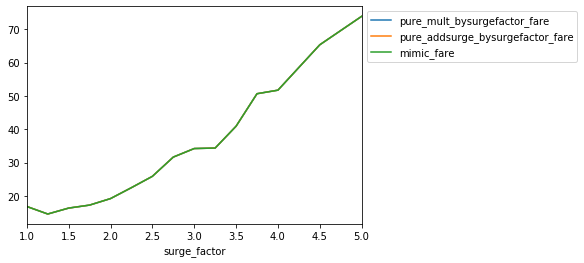

multipliers_by_surge_3weeks = {1.0: 1.1671877175103873, 1.25: 1.2075823324266821, 1.5: 1.2091127573512495, 1.75: 1.2157325050793588, 2.75: 1.196974329650402, 2.5: 1.2103931978344917, 2.0: 1.2178884935565293, 2.25: 1.201058248989284, 3.5: 1.1930283159017563, 3.0: 1.1994396802037954, 3.25: 1.1951863765716553, 4.25: 1.2054145336151123, 3.75: 1.1837195605039597, 4.0: 1.151891052722931, 4.5: 1.1600546538829803, 5.0: 1.1957231909036636}
additives_by_surge_3weeks = {1.0: 50.0, 1.25: 9.766680374741554, 1.5: 9.84233096241951, 1.75: 9.72050204873085, 2.75: 10.660051554441452, 2.5: 9.999258816242218, 2.0: 9.663368202745914, 2.25: 10.235638543963432, 3.5: 11.154604703187943, 3.0: 10.585768520832062, 3.25: 10.938781499862671, 4.25: 9.975481033325195, 3.75: 11.661297082901001, 4.0: 13.611799478530884, 4.5: 13.149338960647583, 5.0: 11.09071969985962}


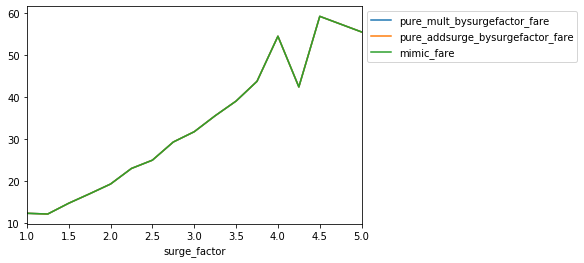

multipliers_by_surge_small = {1.0: 1.1826921254396439, 2.5: 1.196223497390747, 1.25: 1.2130588293075562, 1.75: 1.2060165405273438, 1.5: 1.2314438819885254, 4.25: 1.2330055236816406, 2.25: 1.1376440525054932, 2.0: 1.1940360069274902, 3.75: 1.2015342712402344, 4.0: 1.2253999710083008, 2.75: 1.2584805488586426, 3.0: 1.715087890625, 3.25: 1.4066696166992188, 4.5: 1.0829687118530273, 3.5: 1.1913299560546875}
additives_by_surge_small = {1.0: 50.0, 2.5: 12.680721282958984, 1.25: 9.64803695678711, 1.75: 11.471700668334961, 1.5: 9.272623062133789, 4.25: 8.377456665039062, 2.25: 13.502693176269531, 2.0: 10.048770904541016, 3.75: 9.504318237304688, 4.0: 8.618927001953125, 2.75: 7.673072814941406, 3.0: 4.691314697265625, 3.25: 5.371856689453125, 4.5: 22.4853515625, 3.5: 9.952545166015625}


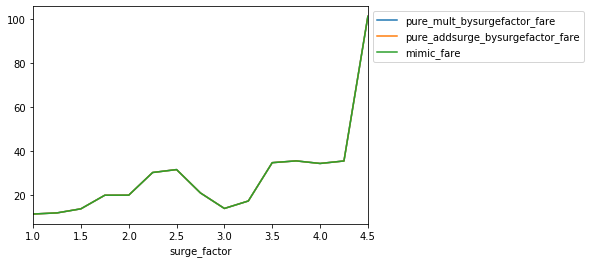

In [15]:
for en, dff in enumerate(dfs):
    find_parameters_for_dataset(dff, df_names[en])